ТЕМА

Определение идентичности российского ВУЗа через новостной контент вебсайта



**Цель** -  выявить идентичность российского ВУЗа через анализ языковых средств в текстах новостей на сайте.

**Исследовательский вопрос**:

Как идентичность проявляется в тех текстах, которые публикуются на сайтах вузов

**Задачи**:

1. Составить перечень ВУЗов, с сайтами которых будем работать (10 вузов разной направленности: политех, спортивный вуз, медицинский,классический...)
2. Отобрать из готового датасета, подготовленного с коллегами во время проекта Приоритет-2030, новости с вебсайтов 10 ВУЗов.
3. Сделать дополнительный парсинг, если не хватает новостей.
4. Предобработать данные.
5. Сделать тематическое моделирование (LDA)- 5-10 кластеров по 15 слов.
6. Выявить общие темы для современного ВУЗА.
7. Выявить специфические темы для каждого из ВУЗов.
8. Проанализировать частотные 2-граммы или 4-граммы для уточнения названия кластеров.
9. Сделать синтаксическую разметку текстов.
10. Найти триплеты - подлежащее, сказумое и дополнение?
11. Сделать анализ контекстов справа и слева - конкордансы.


**Материал исследования** - тексты, размещенные на сайтах российских ВУЗов на русском языке.

Пайплайн

1. Сбор материала с вебсайтов 10 вузов по 20-100 новостных текстов с каждого (готовый датасет в txt + Скрейпинг новых - requests)
2. Загрузка данных в датафрейм (pandas)
Создание общего корпуса (всех вузов) и подкорпусов (каждого в отдельности).
3. Токенизация и лемматизация текстов (pymorphy)
4. Кластеризация подкорпусов (LDA)
5. Синтаксическая разметка (pymorphy или Natasha)
6. Аанализ левого и правого контекста с названием или аббревиатурой ВУЗа (актор/действие)



In [ ]:
import os
import pandas as pd
from nltk import word_tokenize

import nltk
nltk.download('punkt')

from nltk.tokenize import WordPunctTokenizer

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')

import string

!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from sklearn.decomposition import LatentDirichletAllocation

!pip install pyldavis

import pyLDAvis
#import pyLDAvis.sklearn

In [ ]:
!pip install requests
!pip install bs4

In [ ]:
import requests as rq
from bs4 import BeautifulSoup

In [ ]:
#url = "https://tpu.ru"
url = "https://news.tpu.ru/news/?university=true"
all_urls = []
page = rq.get(url)
soup = BeautifulSoup(page.text, features = "html.parser")
containers = soup.find_all("div", class_= "news__content")
for container in containers:
    news_url = container.find("a").get("href")
    all_urls.append(news_url)
print(len(all_urls))

ЗАГРУЗКА ДАННЫХ

In [ ]:
def get_data():
    corpus = []
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open (filename, 'r', encoding = 'utf-8') as f:
                text = f.read()
                corpus.append(text)
    return corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
corpus = get_data()
corpus

СОЗДАНИЕ ТАБЛИЦЫ С ДАННЫМИ

In [ ]:
df = pd.DataFrame(corpus, columns = ['text'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
0,Актуальные задачи современной химической науки...
1,Исследователи Томского политеха совместно с ко...
2,В Томском политехническом университете в рамка...
3,How do learners use a CALL environment? An eye...
4,В Томском политехе начала работу XXIII Междуна...


ТОКЕНИЗАЦИЯ И ЛЕММАТИЗАЦИЯ ТЕКСТА

In [ ]:
def preprocess_data(text):
    text = text.lower()
    text_tokens = WordPunctTokenizer().tokenize(text)
    spec_chars = string.punctuation + '\n\xa0«»\t—...'
    text_tokens = [token for token in text_tokens if
                   (token not in stopwords and token not in spec_chars and not any(char.isdigit() for char in token))]

    text_lemmatized = [morph.parse(token)[0].normal_form for token in text_tokens]

    return " ".join(text_lemmatized)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = df.applymap(preprocess_data) # загружаем обработанный текст в нашу таблицу

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
preprocess_data(df.iloc[0].text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'актуальный задача современный химический наука обсудить участник международный конференция химия химический технология xxi век », завершиться томский политех пленарный заседание доклад выступить известный российский исследователь ведущий академический институт вуз страна который вести совместный проект учёный тпу тема доклад посвятить разработка область биомедицина создание новый органический материал молекулярный машина лекарственный препарат томский политех традиционно становиться коммуникационный площадка обсуждение актуальный вопрос химия химический технология дискуссия присоединяться представитель вуз российский иностранный научный организация предприятие отраслевой научно исследовательский институт общеобразовательный учреждение год конференция собрать рекордный количество участник докладчик страна мир открытие конференция прозвучать четыре пленарный доклад прочесть ведущий учёный иркутск москва санкт петербург важный мысль который сводиться четыре доклад открытие современный на

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
0,актуальный задача современный химический наука...
1,исследователь томский политех совместно коллег...
2,томский политехнический университет рамка прог...
3,how do learners use a call environment an eye ...
4,томский политех начало работа xxiii международ...


ВЕКТОРИЗАЦИЯ

In [ ]:
type(df['text'].tolist()) # делаем список
texts = df['text'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tfidf = tfidf_vectorizer.fit_transform(texts)
print(tfidf)

In [ ]:
tfidf.shape
tfidf.todense()[0].tolist()

In [ ]:
tfidf_vectorizer.vocabulary_

In [ ]:
words = tfidf_vectorizer.get_feature_names_out()[:15]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
np.argsort(tfidf_vectorizer.vocabulary_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0])

In [ ]:
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

for i, article in enumerate(df.text.head()):
        article_vector = tfidf[i, :]
        words = get_top_tf_idf_words(article_vector, feature_names, 10)
        print(article)
        print(words, '\n')

актуальный задача современный химический наука обсудить участник международный конференция химия химический технология xxi век », завершиться томский политех пленарный заседание доклад выступить известный российский исследователь ведущий академический институт вуз страна который вести совместный проект учёный тпу тема доклад посвятить разработка область биомедицина создание новый органический материал молекулярный машина лекарственный препарат томский политех традиционно становиться коммуникационный площадка обсуждение актуальный вопрос химия химический технология дискуссия присоединяться представитель вуз российский иностранный научный организация предприятие отраслевой научно исследовательский институт общеобразовательный учреждение год конференция собрать рекордный количество участник докладчик страна мир открытие конференция прозвучать четыре пленарный доклад прочесть ведущий учёный иркутск москва санкт петербург важный мысль который сводиться четыре доклад открытие современный нау

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_2 = df.applymap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_2

КЛАСТЕРИЗАЦИЯ с LDA

In [ ]:
lda = LatentDirichletAllocation(n_components=5, max_iter=10,learning_offset=10)

lda.fit(tfidf)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_offset=10, n_components=5)

In [ ]:
# матрица "темы x слова"
lda.components_.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10, 8553)

In [ ]:
# viz
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Что за темы получились, и что за слова в них присутствуют?

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):

    fig, axes = plt.subplots(1, 5, figsize=(30, 15)) # параметры отображения
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь

        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
n_top_words = 15

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


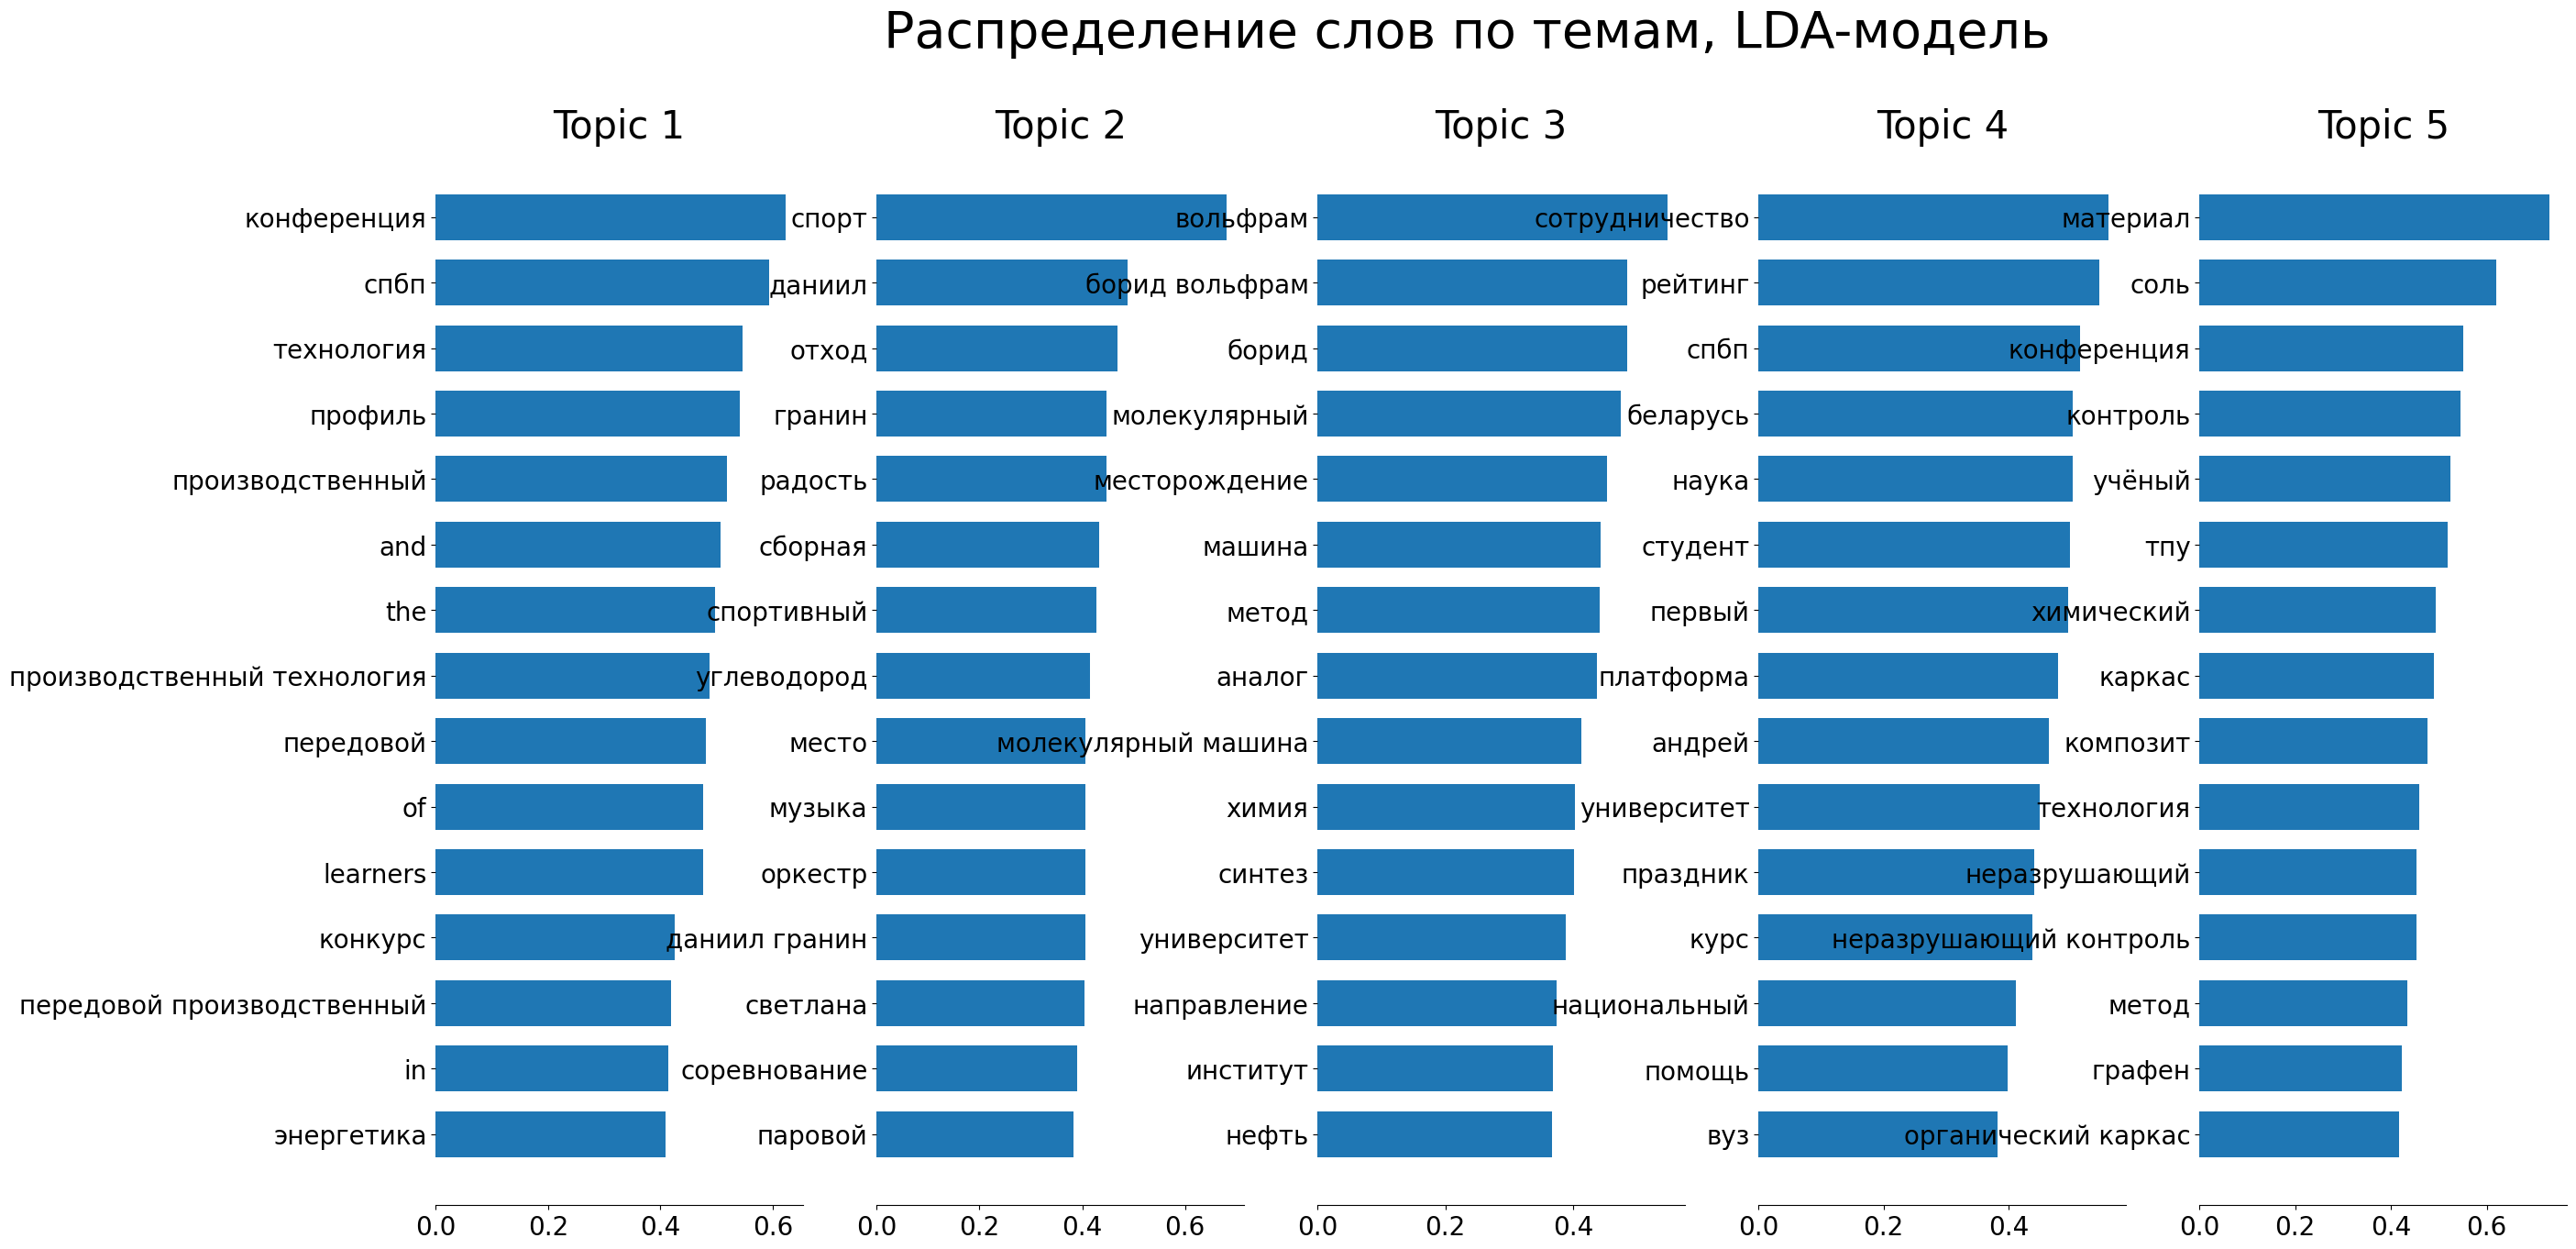

In [ ]:
tf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, n_top_words,'Распределение слов по темам, LDA-модель')